## Problem Statement
HELP International is an international humanitarian NGO that is committed to fighting poverty and providing the people of backward countries with basic amenities and relief during the time of disasters and natural calamities. It runs a lot of operational projects from time to time along with advocacy drives to raise awareness as well as for funding purposes.

 

After the recent funding programmes, they have been able to raise around $ 10 million. Now the CEO of the NGO needs to decide how to use this money strategically and effectively. The significant issues that come while making this decision are mostly related to choosing the countries that are in the direst need of aid. 

 

And this is where you come in as a data analyst. Your job is to categorise the countries using some socio-economic and health factors that determine the overall development of the country. Then you need to suggest the countries which the CEO needs to focus on the most.  The datasets containing those socio-economic factors and the corresponding data dictionary are provided below

The steps are broadly:
1. Read and understand the data
2. Clean the data
3. Prepare the data for modelling
4. Modelling
5. Final analysis 

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

### 1. Reading the data

In [138]:
countries=pd.read_csv("Country-data.csv")
names=countries.country

In [139]:
df = pd.read_csv("Country-data.csv")
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [141]:
df.shape

(167, 10)

In [142]:
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


### 2.Cleaning the data

In [143]:
round(100*(df.isnull().sum())/len(df), 2)

country       0.0
child_mort    0.0
exports       0.0
health        0.0
imports       0.0
income        0.0
inflation     0.0
life_expec    0.0
total_fer     0.0
gdpp          0.0
dtype: float64

 We did not find null values

### Get the data

In [144]:
df= df.drop("country",axis=1)

In [145]:
df['exports']=df['exports']*df['gdpp']/100
df['imports']=df['imports']*df['gdpp']/100
df['health']=df['health']*df['gdpp']/100
df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


### Preprocess data

#### Feature Correlations

In [146]:
rfm_data= df

In [147]:
rfm_data.corr()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
child_mort,1.000000,-0.297230,-0.430438,-0.319138,-0.524315,0.288276,-0.886676,0.848478,-0.483032
exports,-0.297230,1.000000,0.612919,0.987686,0.725351,-0.141553,0.377694,-0.291096,0.768894
health,-0.430438,0.612919,1.000000,0.638581,0.690857,-0.253956,0.545626,-0.407984,0.916593
imports,-0.319138,0.987686,0.638581,1.000000,0.672056,-0.179458,0.397515,-0.317061,0.755114
income,-0.524315,0.725351,0.690857,0.672056,1.000000,-0.147756,0.611962,-0.501840,0.895571
inflation,0.288276,-0.141553,-0.253956,-0.179458,-0.147756,1.000000,-0.239705,0.316921,-0.221631
life_expec,-0.886676,0.377694,0.545626,0.397515,0.611962,-0.239705,1.000000,-0.760875,0.600089
total_fer,0.848478,-0.291096,-0.407984,-0.317061,-0.501840,0.316921,-0.760875,1.000000,-0.454910
gdpp,-0.483032,0.768894,0.916593,0.755114,0.895571,-0.221631,0.600089,-0.454910,1.000000


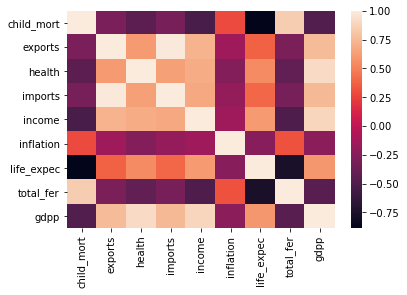

In [148]:
sns.heatmap(rfm_data.corr())

In [149]:
rfm_data.skew()

child_mort    1.450774
exports       6.720171
health        2.526029
imports       6.618500
income        2.231480
inflation     5.154049
life_expec   -0.970996
total_fer     0.967092
gdpp          2.218051
dtype: float64

##### Some of the data is skewed.

### Transforming the data for clearer picture

Scaling/standardization is necessary when because lets consider a feature that has money and another feature which is age,in this case money mostly will be much much higher than the age,and when we will perform fit it might not produce optimum results.This is why we scale/standardize the data before clustering 

In [150]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()
log_data=pd.DataFrame(pt.fit_transform(rfm_data))
log_data.columns=rfm_data.columns

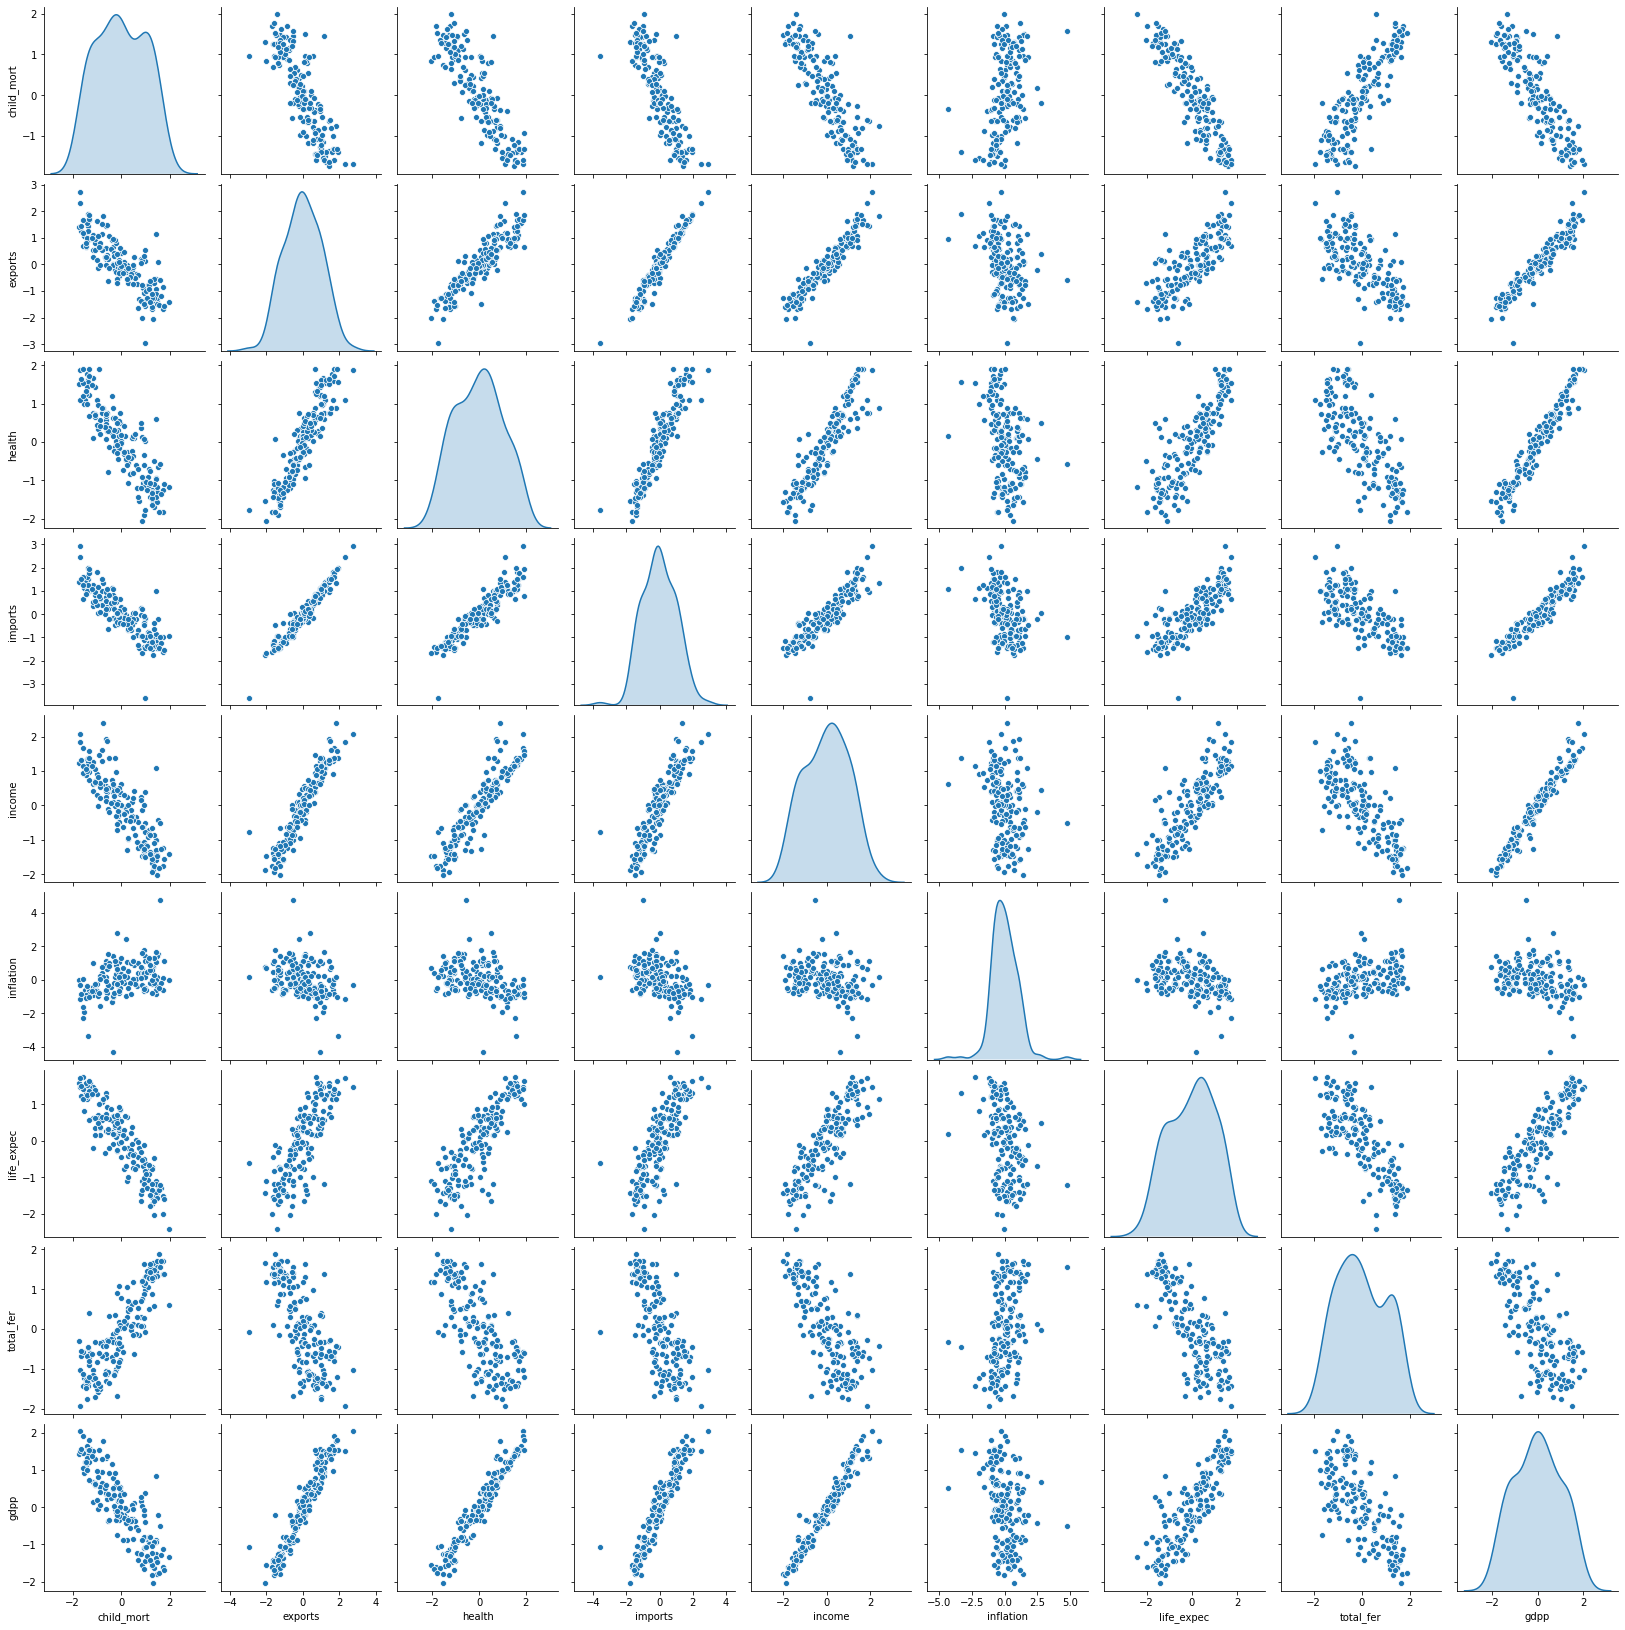

In [151]:
sns.pairplot(log_data,diag_kind='kde')

In [152]:
log_data.corr()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
child_mort,1.000000,-0.828179,-0.881659,-0.852726,-0.858146,0.441530,-0.913226,0.864808,-0.875812
exports,-0.828179,1.000000,0.907956,0.972217,0.940981,-0.330282,0.776561,-0.686132,0.945373
health,-0.881659,0.907956,1.000000,0.923833,0.918039,-0.373798,0.837782,-0.735039,0.969342
imports,-0.852726,0.972217,0.923833,1.000000,0.902035,-0.411520,0.788392,-0.699550,0.932625
income,-0.858146,0.940981,0.918039,0.902035,1.000000,-0.267740,0.838381,-0.746061,0.974392
inflation,0.441530,-0.330282,-0.373798,-0.411520,-0.267740,1.000000,-0.376364,0.397479,-0.333937
life_expec,-0.913226,0.776561,0.837782,0.788392,0.838381,-0.376364,1.000000,-0.782327,0.849122
total_fer,0.864808,-0.686132,-0.735039,-0.699550,-0.746061,0.397479,-0.782327,1.000000,-0.729164
gdpp,-0.875812,0.945373,0.969342,0.932625,0.974392,-0.333937,0.849122,-0.729164,1.000000


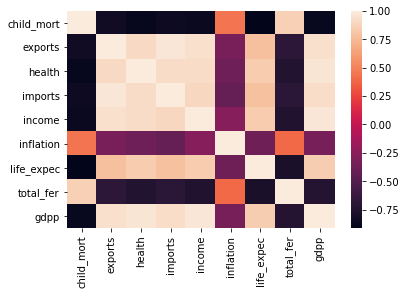

In [153]:
sns.heatmap(log_data.corr())

#### Checking for outliers


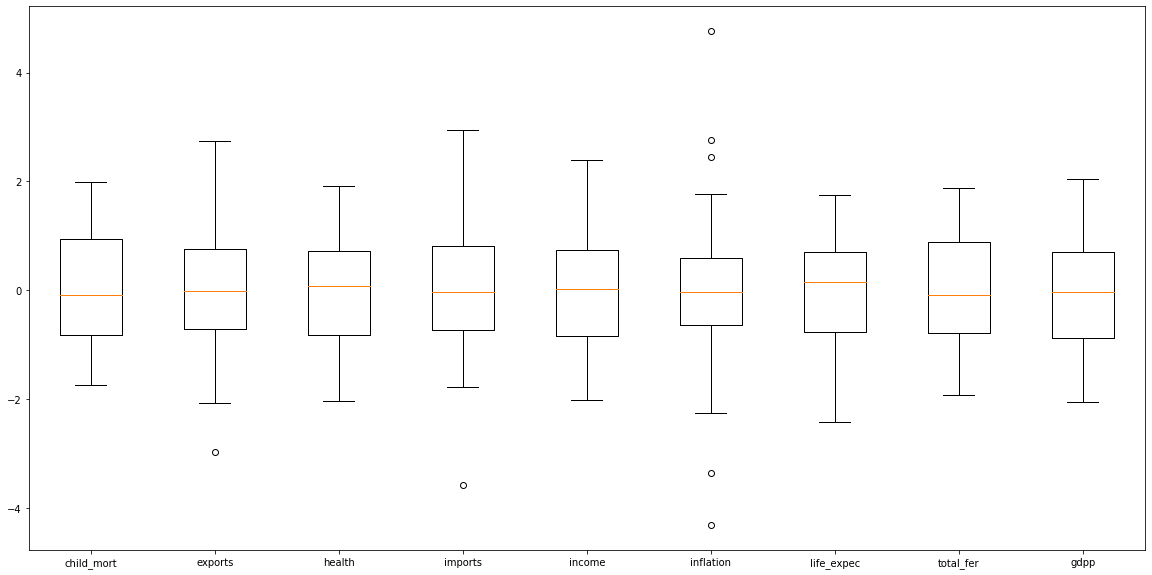

In [191]:
#Checking outliers
X=[log_data.child_mort,log_data.exports,log_data.health,log_data.imports,log_data.income,log_data.inflation,log_data.life_expec,log_data.total_fer,log_data.gdpp]
name=["child_mort","exports","health","imports","income","inflation","life_expec","total_fer","gdpp"]
plt.figure(figsize=(20,10))
plt.boxplot(X,labels=name)
plt.show()

>> There are few outliers in inflation,most of the features dont have outliers so we are not going to do any outlier treatment

#### We can see that there is strong correlation between features

In [154]:
log_data.skew()

child_mort    0.015754
exports      -0.011631
health        0.028684
imports       0.008375
income       -0.035867
inflation     0.182506
life_expec   -0.184956
total_fer     0.136536
gdpp          0.001120
dtype: float64

#### Data is nearer to zero,its not skewed

### K means implementaion
#### We need to determine how many clusters we need to expect 
###### Initialisation of k is very important

In [155]:
rfm_df=log_data

In [156]:
#Checking optimal number of clusters
cluster_range= range(1,15)
cluster_errors=[]
cluster_sil_scores = []
for num_clusters in cluster_range:
    clusters = KMeans(num_clusters,n_init=100,init='k-means++',random_state=0)
    clusters.fit(rfm_df)
    labels = clusters.cluster_centers_
    cluster_errors.append(clusters.inertia_)
    
clusters_df = pd.DataFrame({"num_clusters":cluster_range,"cluster_errors":cluster_errors})
clusters_df[0:10]

,num_clusters,cluster_errors
0,1,1503.000000
1,2,650.272277
2,3,418.810059
3,4,364.853287
4,5,326.424231
5,6,295.866871
6,7,272.856040
7,8,252.504214
8,9,236.740115
9,10,224.203489


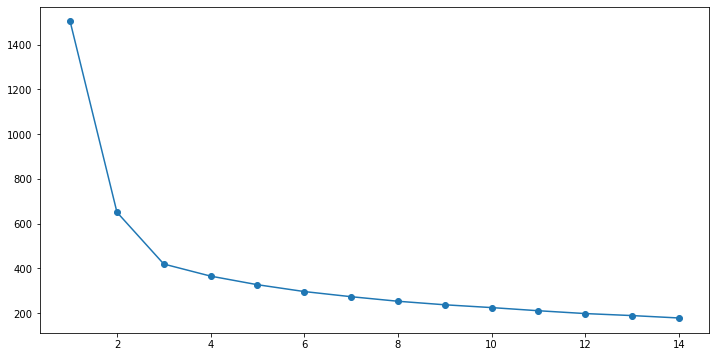

In [157]:

# elbow-curve/SSD
plt.figure(figsize=(12,6))
plt.plot(clusters_df.num_clusters,clusters_df.cluster_errors,marker="o")


> We Can see that there is lesser deviation from 2 to 3 so it looks like 3 clusters

In [158]:
## Fitting and predicting

kmeans= KMeans(n_clusters=3,n_init=100,init="k-means++",random_state=0)
#fitting the data
kmeans= kmeans.fit(rfm_df)

#predicting the data
labels = kmeans.predict(rfm_df)

centroids=kmeans.cluster_centers_

print("centroid values")
print("sklearn")
print(centroids)

centroid values
sklearn
[[ 1.17330507 -1.14975736 -1.17619414 -1.13618535 -1.20962975  0.43422925
  -1.12302598  1.13631868 -1.19390869]
 [-0.04128765  0.03358007  0.03112836 -0.00248561  0.09416955  0.23550992
   0.07353174 -0.18750883  0.03708553]
 [-1.18670464  1.17313325  1.20490898  1.21240979  1.14658763 -0.81270547
   1.08519313 -0.92958118  1.21488186]]


In [159]:
prediction = kmeans.predict(rfm_df)
df1=pd.DataFrame(rfm_df,columns=log_data.columns)
df1["group"] = prediction

In [160]:
df1.head(10)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,group
0,1.266699,-1.658719,-1.239313,-1.246055,-1.368935,0.459416,-1.526455,1.544053,-1.462273,0
1,-0.220994,-0.238427,-0.042924,-0.055108,0.012538,-0.154659,0.621738,-0.992833,-0.121133,1
2,0.217834,-0.030785,-0.270052,-0.266188,0.232275,1.059790,0.652698,0.313175,-0.063195,1
3,1.506186,0.100544,-0.661987,-0.219429,-0.408251,1.512843,-1.239045,1.623128,-0.219666,0
4,-0.637380,0.602677,0.563269,0.758134,0.572583,-0.723442,0.699553,-0.368063,0.609228,2
5,-0.339697,0.036270,0.636466,-0.168627,0.553895,1.412022,0.545301,-0.120706,0.496207,1
6,-0.144877,-0.508145,-0.442152,-0.241864,-0.307448,0.275860,0.183248,-0.932506,-0.281188,1
7,-1.277117,0.950906,1.572599,1.032075,1.282892,-0.793127,1.594457,-0.604207,1.574088,2
8,-1.364807,1.451427,1.640826,1.531545,1.323552,-0.870154,1.319778,-1.341021,1.506685,2
9,0.537221,0.296020,0.109133,-0.353539,0.417398,0.870730,-0.353603,-0.616839,0.117089,1


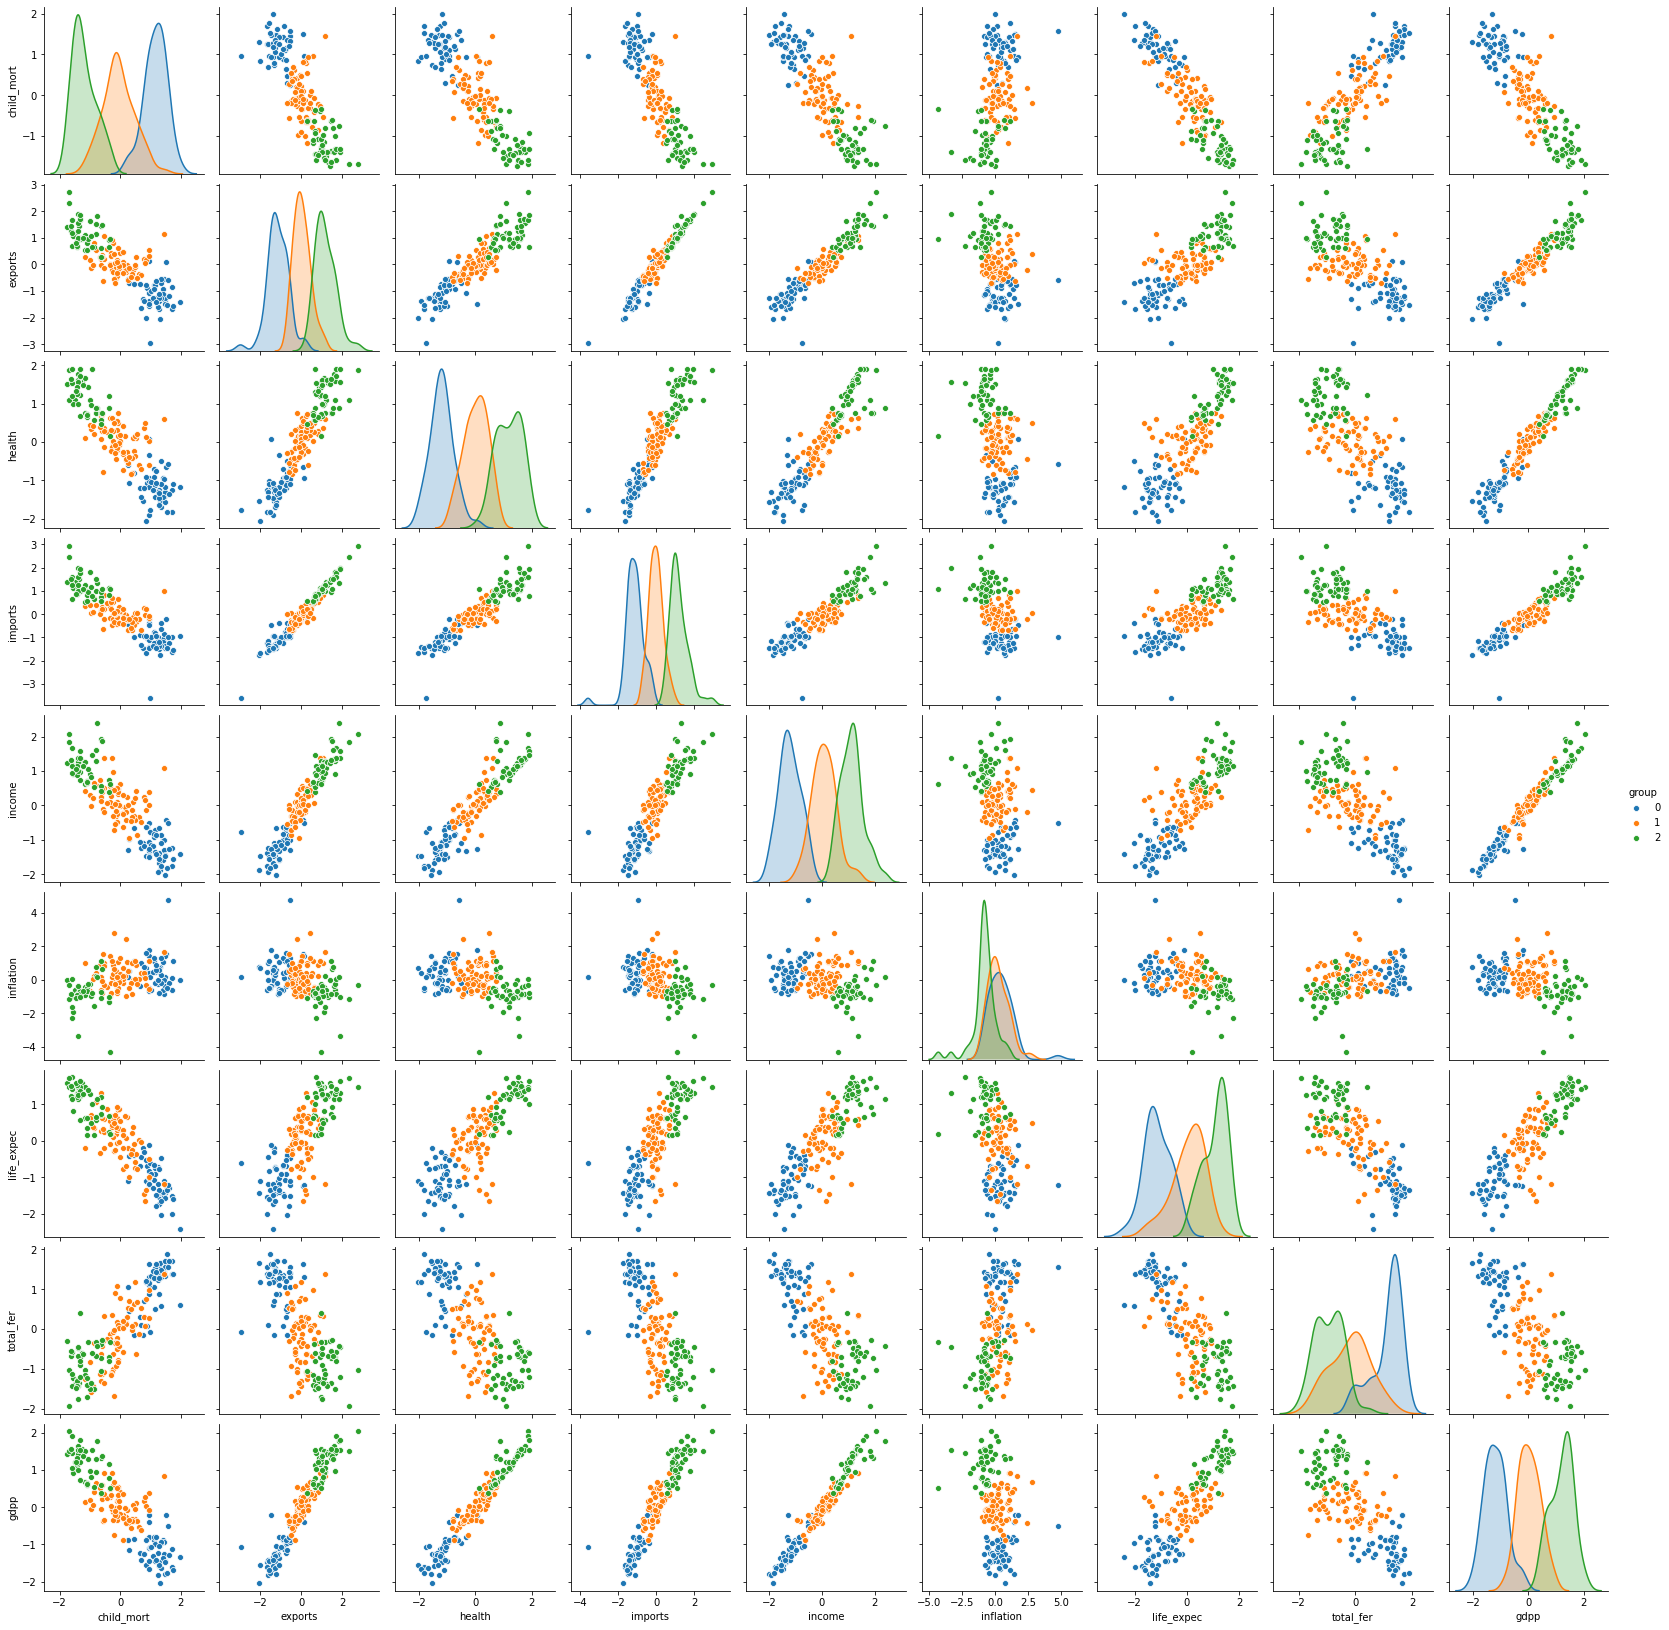

In [161]:
sns.pairplot(df1,diag_kind="kde",hue="group")

[]

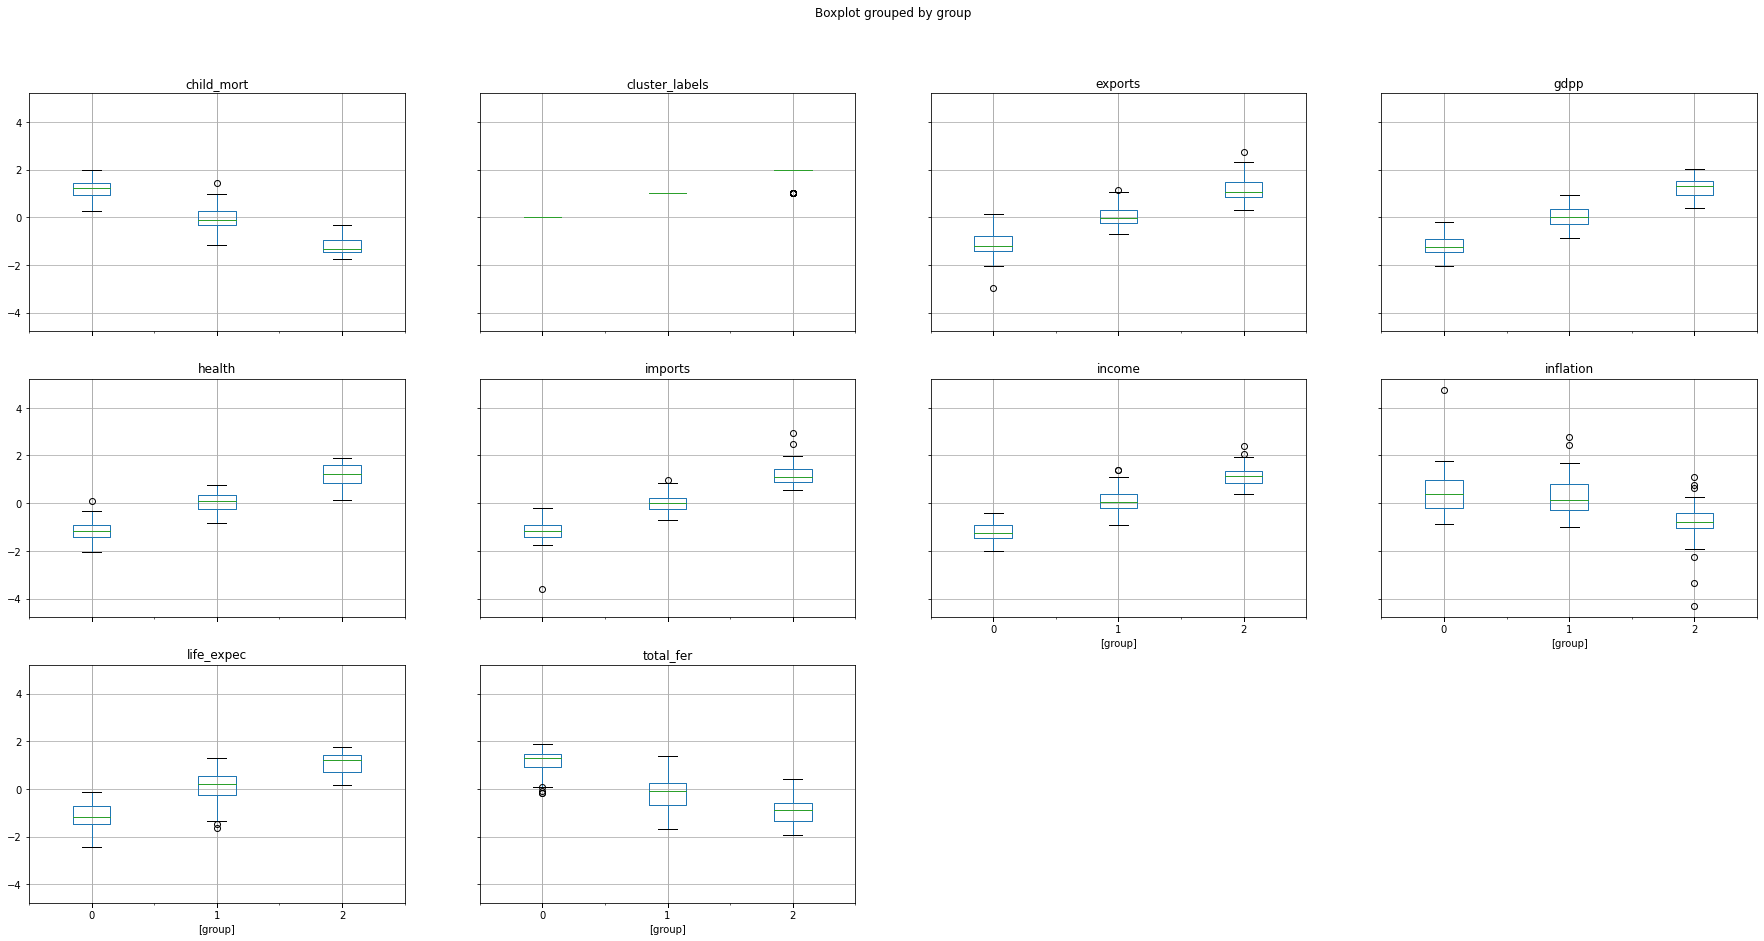

In [193]:
df1.boxplot(by="group",layout=(3,4),figsize=(30,15))
plt.plot()

### some conclusions from above box plots
>1.Group 0 has highest child mortality rate,highest imports,lowest exports,lowest gppp,lowest income, high inflation,low life expetancy and very high fetility rate

>2.Group 1 scores better on all social indicators than group 0.There are developing countries

>3.Group 2 scores best on all social indicators and it indicates that they are developed countries

In [163]:
from __future__ import print_function
%matplotlib inline

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    clusterer = KMeans(n_clusters=num_clusters,n_init = 100,init='k-means++',random_state=0)
    cluster_labels = clusterer.fit_predict(rfm_df)
    
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.44140443197670914
For n_clusters=3, the silhouette score is 0.4253232203633577
For n_clusters=4, the silhouette score is 0.3268958908165983
For n_clusters=5, the silhouette score is 0.29868195476537923
For n_clusters=6, the silhouette score is 0.2557034744334429
For n_clusters=7, the silhouette score is 0.2514647821421646
For n_clusters=8, the silhouette score is 0.262516772466317


## Heirarchical Clustering

In [164]:
rfm_df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,group
0,1.266699,-1.658719,-1.239313,-1.246055,-1.368935,0.459416,-1.526455,1.544053,-1.462273,0
1,-0.220994,-0.238427,-0.042924,-0.055108,0.012538,-0.154659,0.621738,-0.992833,-0.121133,1
2,0.217834,-0.030785,-0.270052,-0.266188,0.232275,1.059790,0.652698,0.313175,-0.063195,1
3,1.506186,0.100544,-0.661987,-0.219429,-0.408251,1.512843,-1.239045,1.623128,-0.219666,0
4,-0.637380,0.602677,0.563269,0.758134,0.572583,-0.723442,0.699553,-0.368063,0.609228,2


In [165]:
log_data.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,group
0,1.266699,-1.658719,-1.239313,-1.246055,-1.368935,0.459416,-1.526455,1.544053,-1.462273,0
1,-0.220994,-0.238427,-0.042924,-0.055108,0.012538,-0.154659,0.621738,-0.992833,-0.121133,1
2,0.217834,-0.030785,-0.270052,-0.266188,0.232275,1.059790,0.652698,0.313175,-0.063195,1
3,1.506186,0.100544,-0.661987,-0.219429,-0.408251,1.512843,-1.239045,1.623128,-0.219666,0
4,-0.637380,0.602677,0.563269,0.758134,0.572583,-0.723442,0.699553,-0.368063,0.609228,2


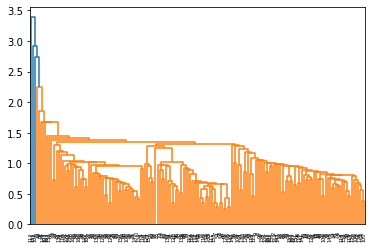

In [166]:
#Single linkage
mergings = linkage(rfm_df, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

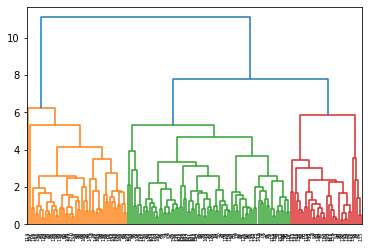

In [167]:

mergings = linkage(rfm_df, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [168]:
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 1, 1, 0, 1, 1, 1, 2, 2, 1, 1, 2, 0, 1, 1, 2, 1, 0, 1, 1, 1, 1,
       1, 2, 1, 0, 0, 0, 0, 2, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 2, 2,
       2, 1, 1, 1, 1, 1, 0, 1, 1, 2, 2, 1, 0, 1, 2, 0, 2, 1, 1, 0, 0, 1,
       0, 1, 2, 0, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 0, 0, 2, 0, 0, 1, 1, 0,
       0, 1, 1, 2, 1, 0, 0, 1, 1, 0, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       2, 2, 0, 0, 2, 1, 0, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 1, 1, 0, 1, 2,
       0, 2, 1, 2, 0, 1, 2, 2, 1, 1, 0, 1, 2, 2, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 2, 2, 2, 1, 0, 1, 1, 1, 0, 0])

In [169]:
# assign cluster labels
rfm_df["cluster_labels"]= cluster_labels
rfm_df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,group,cluster_labels
0,1.266699,-1.658719,-1.239313,-1.246055,-1.368935,0.459416,-1.526455,1.544053,-1.462273,0,0
1,-0.220994,-0.238427,-0.042924,-0.055108,0.012538,-0.154659,0.621738,-0.992833,-0.121133,1,1
2,0.217834,-0.030785,-0.270052,-0.266188,0.232275,1.059790,0.652698,0.313175,-0.063195,1,1
3,1.506186,0.100544,-0.661987,-0.219429,-0.408251,1.512843,-1.239045,1.623128,-0.219666,0,0
4,-0.637380,0.602677,0.563269,0.758134,0.572583,-0.723442,0.699553,-0.368063,0.609228,2,1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002DD7F2F5E48>,
      dtype=object)

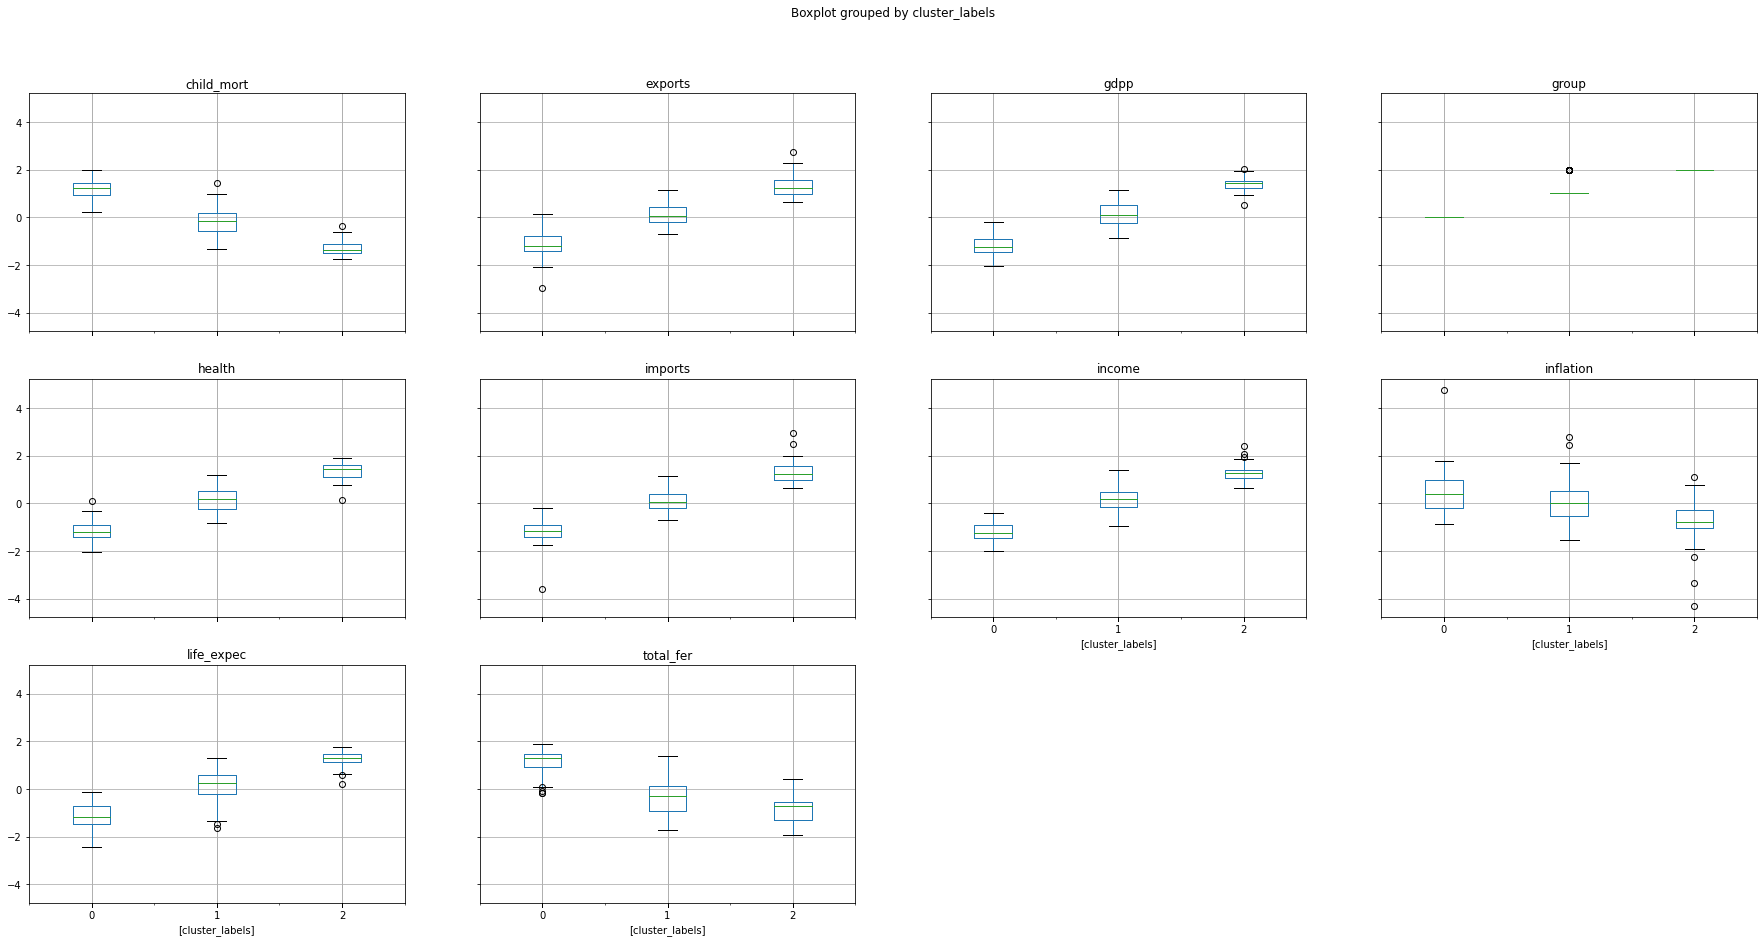

In [170]:
#Visualising using boxplot
rfm_df.boxplot(by="cluster_labels",layout=(3,4),figsize=(30,15))


> Above box plot suggests same results as k- means 

In [171]:
rfm_df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,group,cluster_labels
0,1.266699,-1.658719,-1.239313,-1.246055,-1.368935,0.459416,-1.526455,1.544053,-1.462273,0,0
1,-0.220994,-0.238427,-0.042924,-0.055108,0.012538,-0.154659,0.621738,-0.992833,-0.121133,1,1
2,0.217834,-0.030785,-0.270052,-0.266188,0.232275,1.059790,0.652698,0.313175,-0.063195,1,1
3,1.506186,0.100544,-0.661987,-0.219429,-0.408251,1.512843,-1.239045,1.623128,-0.219666,0,0
4,-0.637380,0.602677,0.563269,0.758134,0.572583,-0.723442,0.699553,-0.368063,0.609228,2,1


In [172]:
names

0              Afghanistan
1                  Albania
2                  Algeria
3                   Angola
4      Antigua and Barbuda
              ...         
162                Vanuatu
163              Venezuela
164                Vietnam
165                  Yemen
166                 Zambia
Name: country, Length: 167, dtype: object

In [173]:
rfm_df["Name"]=names

In [174]:
rfm_df

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,group,cluster_labels,Name
0,1.266699,-1.658719,-1.239313,-1.246055,-1.368935,0.459416,-1.526455,1.544053,-1.462273,0,0,Afghanistan
1,-0.220994,-0.238427,-0.042924,-0.055108,0.012538,-0.154659,0.621738,-0.992833,-0.121133,1,1,Albania
2,0.217834,-0.030785,-0.270052,-0.266188,0.232275,1.059790,0.652698,0.313175,-0.063195,1,1,Algeria
3,1.506186,0.100544,-0.661987,-0.219429,-0.408251,1.512843,-1.239045,1.623128,-0.219666,0,0,Angola
4,-0.637380,0.602677,0.563269,0.758134,0.572583,-0.723442,0.699553,-0.368063,0.609228,2,1,Antigua and Barbuda
...,...,...,...,...,...,...,...,...,...,...,...,...
162,0.277273,-0.141271,-0.381286,-0.199630,-0.936193,-0.471307,-0.989750,0.697493,-0.335292,1,1,Vanuatu
163,-0.194898,0.400861,0.502256,0.054132,0.444169,2.762706,0.485134,-0.027463,0.676806,1,1,Venezuela
164,0.077880,-0.336923,-0.737143,-0.436152,-0.620553,0.719890,0.155698,-0.579193,-0.883717,1,1,Vietnam
165,0.855552,-0.768366,-0.919132,-0.920014,-0.622263,1.590866,-0.536108,1.208599,-0.883717,0,0,Yemen


### countries which are in dire need of help using heirachical

In [175]:


cluster_0 = rfm_df[rfm_df["cluster_labels"]==0]

In [176]:
cluster_0.sort_values(by=["gdpp","child_mort","income"],ascending=True).head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,group,cluster_labels,Name
26,1.298780,-2.063795,-1.541130,-1.770468,-1.867384,0.738196,-1.422077,1.645014,-2.048077,0,0,Burundi
88,1.257999,-1.606617,-1.294897,-1.138832,-1.923514,-0.013415,-1.181773,1.323867,-1.814890,0,0,Liberia
37,1.484194,-1.259150,-1.550729,-1.460581,-2.011864,1.405163,-1.436428,1.703294,-1.800675,0,0,"Congo, Dem. Rep."
112,1.534638,-1.514535,-1.813260,-1.444379,-1.826407,-0.484814,-1.340700,1.873128,-1.773118,0,0,Niger
132,1.759989,-1.576152,-1.091915,-1.556923,-1.558710,1.145065,-1.604688,1.378219,-1.681334,0,0,Sierra Leone


### countries which are in dire need of help using K-means

In [180]:

poor_countries=rfm_df[rfm_df["group"]==0]
poor_countries.sort_values(by=["gdpp","child_mort","income"],ascending=True).head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,group,cluster_labels,Name
26,1.298780,-2.063795,-1.541130,-1.770468,-1.867384,0.738196,-1.422077,1.645014,-2.048077,0,0,Burundi
88,1.257999,-1.606617,-1.294897,-1.138832,-1.923514,-0.013415,-1.181773,1.323867,-1.814890,0,0,Liberia
37,1.484194,-1.259150,-1.550729,-1.460581,-2.011864,1.405163,-1.436428,1.703294,-1.800675,0,0,"Congo, Dem. Rep."
112,1.534638,-1.514535,-1.813260,-1.444379,-1.826407,-0.484814,-1.340700,1.873128,-1.773118,0,0,Niger
132,1.759989,-1.576152,-1.091915,-1.556923,-1.558710,1.145065,-1.604688,1.378219,-1.681334,0,0,Sierra Leone


### developing countries

In [199]:
#using clustering
developing = rfm_df[rfm_df["cluster_labels"]==1]
developing.sort_values(by=["gdpp","child_mort","income"],ascending=False).head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,group,cluster_labels,Name
10,-0.383009,0.923662,1.186002,1.113494,0.734393,-1.332789,0.253026,-0.694429,1.163235,2,1,Bahamas
128,-0.269965,0.910220,0.632050,0.679118,1.371222,1.145065,0.440576,0.363114,0.915225,1,1,Saudi Arabia
115,-0.526959,1.072447,0.375276,0.824884,1.369101,1.019990,0.590999,0.320416,0.915225,1,1,Oman
49,1.446207,1.157620,0.586896,0.982255,1.088662,1.672971,-1.173443,1.381149,0.834514,1,1,Equatorial Guinea
134,-0.966684,1.071791,0.955567,1.150168,0.820906,-0.985938,0.500094,-1.359059,0.814720,2,1,Slovak Republic


In [200]:
#using k-means
developing_k=rfm_df[rfm_df["group"]==1]
developing_k.sort_values(by=["gdpp","child_mort","income"],ascending=False).head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,group,cluster_labels,Name
128,-0.269965,0.910220,0.632050,0.679118,1.371222,1.145065,0.440576,0.363114,0.915225,1,1,Saudi Arabia
115,-0.526959,1.072447,0.375276,0.824884,1.369101,1.019990,0.590999,0.320416,0.915225,1,1,Oman
49,1.446207,1.157620,0.586896,0.982255,1.088662,1.672971,-1.173443,1.381149,0.834514,1,1,Equatorial Guinea
163,-0.194898,0.400861,0.502256,0.054132,0.444169,2.762706,0.485134,-0.027463,0.676806,1,1,Venezuela
33,-0.782441,0.529394,0.756156,0.385695,0.586368,0.408494,1.075708,-0.668217,0.646466,1,1,Chile


Saudi arabia is developing very fast as per above analysis

### Developed countries

In [198]:
#using clustering
developed=rfm_df[rfm_df["cluster_labels"]==2]
developed.sort_values(by=["gdpp","child_mort","income"],ascending=False).head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,group,cluster_labels,Name
91,-1.690967,2.745091,1.877733,2.940514,2.071346,-0.292719,1.464550,-1.023665,2.042503,2,2,Luxembourg
114,-1.592430,1.676842,1.887941,1.609054,1.680419,0.051302,1.409802,-0.579193,1.923651,2,2,Norway
145,-1.328742,1.871723,1.903342,1.941182,1.566378,-1.041460,1.632134,-1.201732,1.815371,2,2,Switzerland
123,-0.753436,1.817942,0.878323,1.327669,2.395485,0.182021,1.144252,-0.435767,1.775903,2,2,Qatar
44,-1.402312,1.570477,1.769852,1.616509,1.341135,-0.361207,1.144252,-0.681279,1.648009,2,2,Denmark


In [201]:
#using k-means
developed_k=rfm_df[rfm_df["group"]==2]
developed_k.sort_values(by=["gdpp","child_mort","income"],ascending=False).head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,group,cluster_labels,Name
91,-1.690967,2.745091,1.877733,2.940514,2.071346,-0.292719,1.464550,-1.023665,2.042503,2,2,Luxembourg
114,-1.592430,1.676842,1.887941,1.609054,1.680419,0.051302,1.409802,-0.579193,1.923651,2,2,Norway
145,-1.328742,1.871723,1.903342,1.941182,1.566378,-1.041460,1.632134,-1.201732,1.815371,2,2,Switzerland
123,-0.753436,1.817942,0.878323,1.327669,2.395485,0.182021,1.144252,-0.435767,1.775903,2,2,Qatar
44,-1.402312,1.570477,1.769852,1.616509,1.341135,-0.361207,1.144252,-0.681279,1.648009,2,2,Denmark


#### Conclusion
>> Top 5 countries which need help are 
 >1. Barundi
 >2. Liberia
 >3. Congo, Dem. Rep.
 >4. Niger
 >5. Sierra Leone